In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import matplotlib.pyplot as plt 
import pandas as pd
import os
from PIL import Image
from DataPreparation.CustomDataSet import CustomDataSet
from AutoEncoders.SimpleAutoencoder import AutoEncoder
import numpy as np
import pickle
from  sklearn.svm import SVC

In [2]:
from Pruning.laprune import LAP 

In [3]:
def transform(input):
    input = torch.FloatTensor(np.array(input))
    input = input.flatten()
    input = input.type(torch.FloatTensor)
    input -= torch.min(input)
    input /= torch.max(input)
    return input

In [4]:
dataset = data_set = datasets.FashionMNIST("/FashionMNIST/", download=False, transform=transform)

In [5]:
# finding the best parameters for autoencoder 
train_size = int(0.3 * len(dataset))  # int(0.3 * len(dataset)) 80% for training
validation_size = int(0.1*len(dataset))
test_size = 0.1 #len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset, _ = random_split(dataset,[0.1,0.1,0.1, 0.7])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

18000
6000


In [6]:
def train_autoencoder(model, train_loader, val_loader, epochs, lr=0.01):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            model.train()  # Set model to training mode
            total_train_loss = 0
            for X_batch, _ in train_loader:
                X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                optimizer.zero_grad()
                outputs = model(X_batch)
                train_loss = criterion(outputs, X_batch)
                train_loss.backward()
                optimizer.step()
                total_train_loss += train_loss.item()
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

                # Validation
            model.eval()  # Set model to evaluation mode
            total_val_loss = 0
            with torch.no_grad():
                for X_batch, _ in val_loader:
                    X_batch = X_batch.view(X_batch.size(0), -1)  # Reshape if necessary
                    outputs = model(X_batch)
                    val_loss = criterion(outputs, X_batch)
                    total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        return train_losses, val_losses

In [7]:
model = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = train_autoencoder(model, train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.1086, Val Loss: 0.0656
Epoch 2, Train Loss: 0.0538, Val Loss: 0.0439
Epoch 3, Train Loss: 0.0385, Val Loss: 0.0344
Epoch 4, Train Loss: 0.0313, Val Loss: 0.0292
Epoch 5, Train Loss: 0.0279, Val Loss: 0.0272
Epoch 6, Train Loss: 0.0265, Val Loss: 0.0262
Epoch 7, Train Loss: 0.0256, Val Loss: 0.0253
Epoch 8, Train Loss: 0.0248, Val Loss: 0.0246
Epoch 9, Train Loss: 0.0241, Val Loss: 0.0241
Epoch 10, Train Loss: 0.0235, Val Loss: 0.0235
Epoch 11, Train Loss: 0.0231, Val Loss: 0.0230
Epoch 12, Train Loss: 0.0226, Val Loss: 0.0226
Epoch 13, Train Loss: 0.0221, Val Loss: 0.0222
Epoch 14, Train Loss: 0.0217, Val Loss: 0.0218
Epoch 15, Train Loss: 0.0213, Val Loss: 0.0214
Epoch 16, Train Loss: 0.0209, Val Loss: 0.0210
Epoch 17, Train Loss: 0.0205, Val Loss: 0.0206
Epoch 18, Train Loss: 0.0202, Val Loss: 0.0203
Epoch 19, Train Loss: 0.0199, Val Loss: 0.0200
Epoch 20, Train Loss: 0.0196, Val Loss: 0.0198
Epoch 21, Train Loss: 0.0193, Val Loss: 0.0196
Epoch 22, Train Loss: 

In [8]:
def eval_model(model, dataset, classifier):
    #model.eval()
    #criterion = nn.MSELoss()
    #total_loss = 0
    #with torch.no_grad():
     #   for X_batch, _ in data_loader:
     #       X_batch = X_batch.view(X_batch.size(0), -1)
     #       outputs = model(X_batch)
     #       loss = criterion(outputs, X_batch)
     #       total_loss += loss.item()
    #avg_loss = total_loss / len(data_loader)
    with torch.no_grad():
        data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
        for images, labels in data_loader:
            reconstructed = model(images)
            accuracy = classifier.score(reconstructed.detach().numpy(), labels)
            
            return accuracy


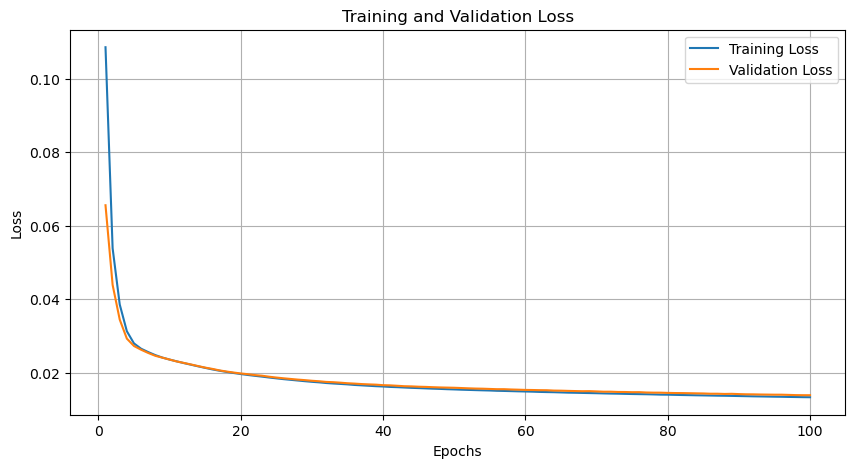

In [9]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are the lists returned from the train_autoencoder method
epochs = range(1, 100 + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
with open("Classifiers/CorrputedFashionMNISTClassifier_no_noise.pkl", "rb") as f:
    fashion_mnist_classifier = pickle.load(f)

In [11]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels_LAP = []  # This will store the actual sparsity levels calculated from the model
test_losses_LAP = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels_LAP.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, fashion_mnist_classifier)
    test_losses_LAP.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


Prune Ratio: 0.2, Actual Sparsity Level: 0.1796, Test Loss: 0.8613
Prune Ratio: 0.3, Actual Sparsity Level: 0.2694, Test Loss: 0.8570
Prune Ratio: 0.4, Actual Sparsity Level: 0.3592, Test Loss: 0.8478
Prune Ratio: 0.5, Actual Sparsity Level: 0.4490, Test Loss: 0.8197
Prune Ratio: 0.6, Actual Sparsity Level: 0.5388, Test Loss: 0.7833
Prune Ratio: 0.7, Actual Sparsity Level: 0.6286, Test Loss: 0.6477
Prune Ratio: 0.8, Actual Sparsity Level: 0.7184, Test Loss: 0.4443
Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1972


In [12]:
import Pruning.ShapSAE as SSAE

In [13]:

test_data = [data for data in test_dataloader]
pruned_model = copy.deepcopy(model)
importances = SSAE.calc_importance(pruned_model,test_data[0][0])

0it [00:00, ?it/s]
100%|██████████| 8/8 [00:55<00:00,  6.94s/it]
1it [00:55, 55.53s/it]
100%|██████████| 21/21 [02:28<00:00,  7.09s/it]
3it [03:24, 69.54s/it]
100%|██████████| 251/251 [27:23<00:00,  6.55s/it]
5it [30:48, 369.67s/it]


In [14]:


# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []



for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model)
    
    # Apply LAP pruning using the specified prune ratio
    pruned_model, _ = SSAE.prune(pruned_model, importances, ratio)
    
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, fashion_mnist_classifier)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")

5it [00:00, 970.01it/s]


Prune Ratio: 0.2, Actual Sparsity Level: 0.8082, Test Loss: 0.2470


5it [00:00, 793.65it/s]


Prune Ratio: 0.3, Actual Sparsity Level: 0.8082, Test Loss: 0.2305


5it [00:00, 787.84it/s]


Prune Ratio: 0.4, Actual Sparsity Level: 0.8082, Test Loss: 0.1307


5it [00:00, 940.30it/s]


Prune Ratio: 0.5, Actual Sparsity Level: 0.8082, Test Loss: 0.1018


5it [00:00, 801.30it/s]


Prune Ratio: 0.6, Actual Sparsity Level: 0.8082, Test Loss: 0.1028


5it [00:00, 798.55it/s]


Prune Ratio: 0.7, Actual Sparsity Level: 0.8082, Test Loss: 0.1018


5it [00:00, 833.33it/s]


Prune Ratio: 0.8, Actual Sparsity Level: 0.8082, Test Loss: 0.1018


5it [00:00, 750.08it/s]


Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1018


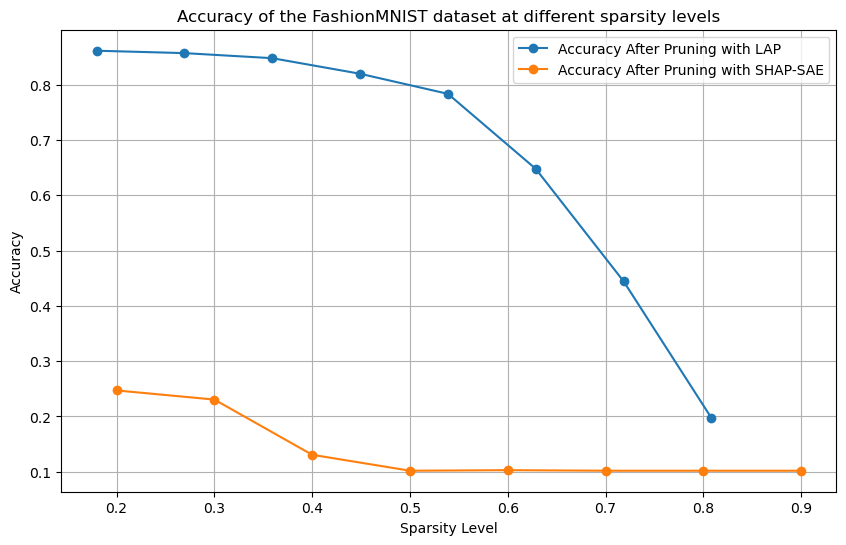

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels_LAP, test_losses_LAP, '-o', label='Accuracy After Pruning with LAP')
plt.plot(prune_ratios, test_losses, '-o', label='Accuracy After Pruning with SHAP-SAE')

plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Accuracy of the FashionMNIST dataset at different sparsity levels')
plt.legend()
plt.grid(True)
plt.show()

5it [00:00, 833.20it/s]
5it [00:00, 833.53it/s]
5it [00:00, 1000.31it/s]
5it [00:00, 832.90it/s]
5it [00:00, 833.43it/s]
5it [00:00, 833.59it/s]
5it [00:00, 999.93it/s]
5it [00:00, 833.43it/s]


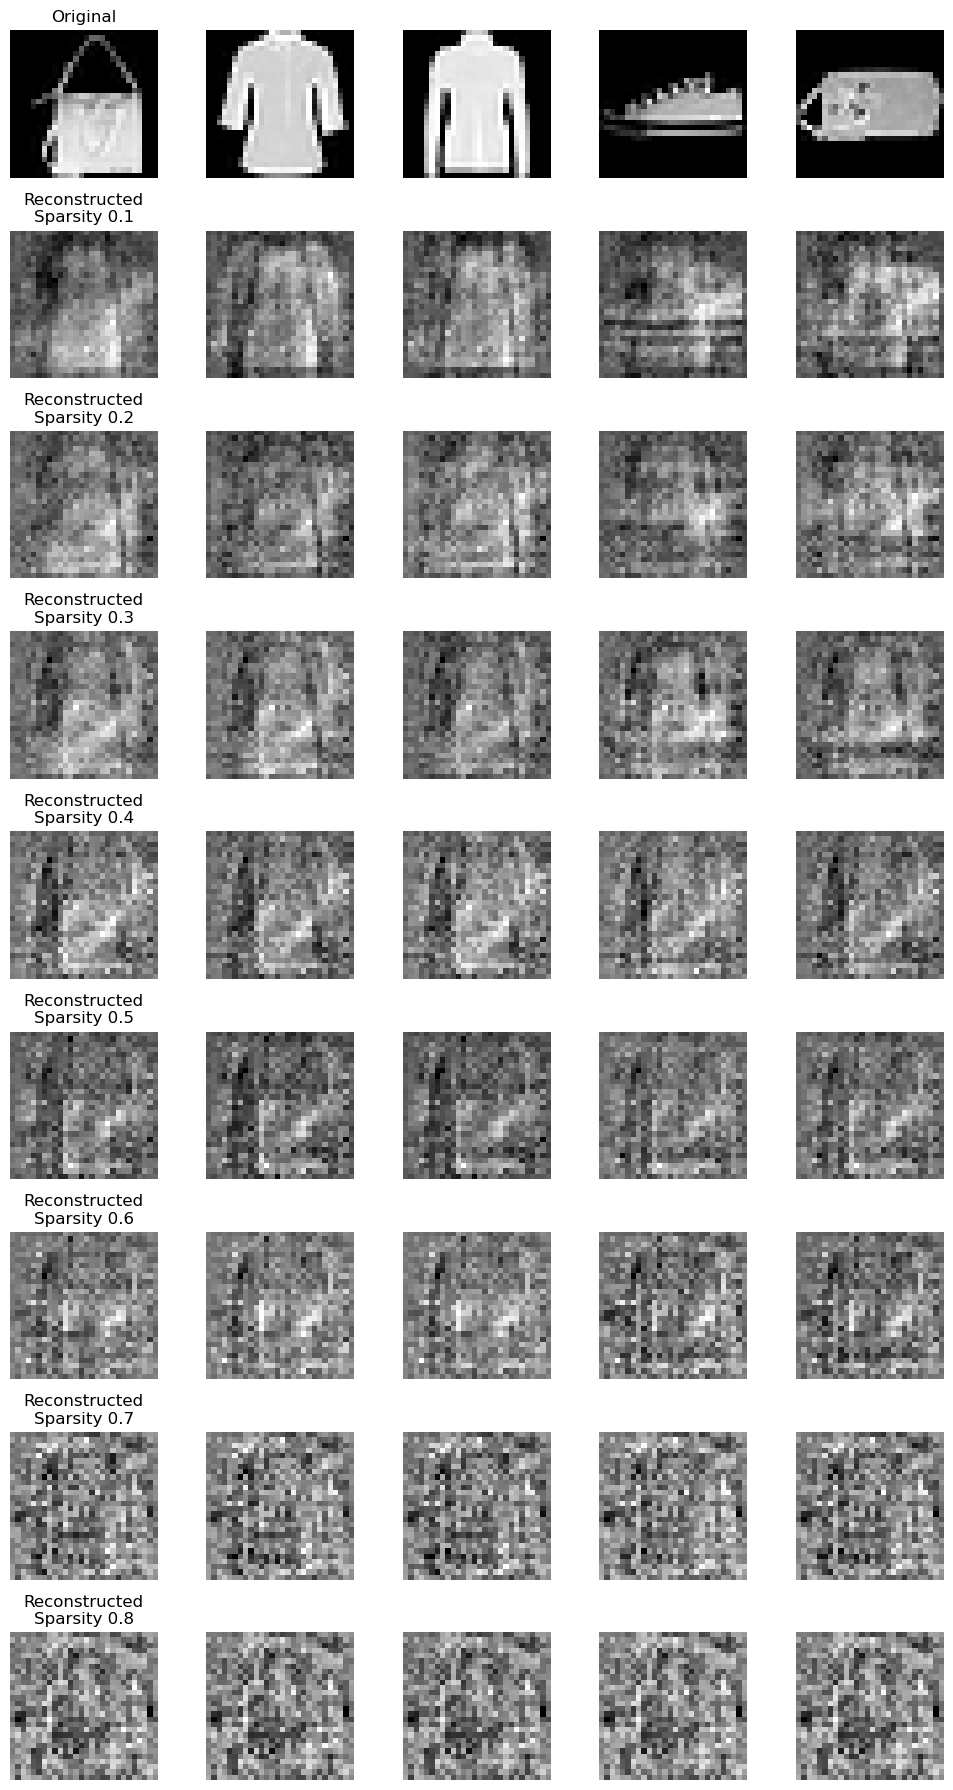

In [16]:
def display_reconstructed_images_SHAP(model, test_dataloader, importances, importance_levels):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(importance_levels, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        pruned_model, _ = SSAE.prune(pruned_model, importances, sparsity)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

display_reconstructed_images_SHAP(model, test_dataloader, importances, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

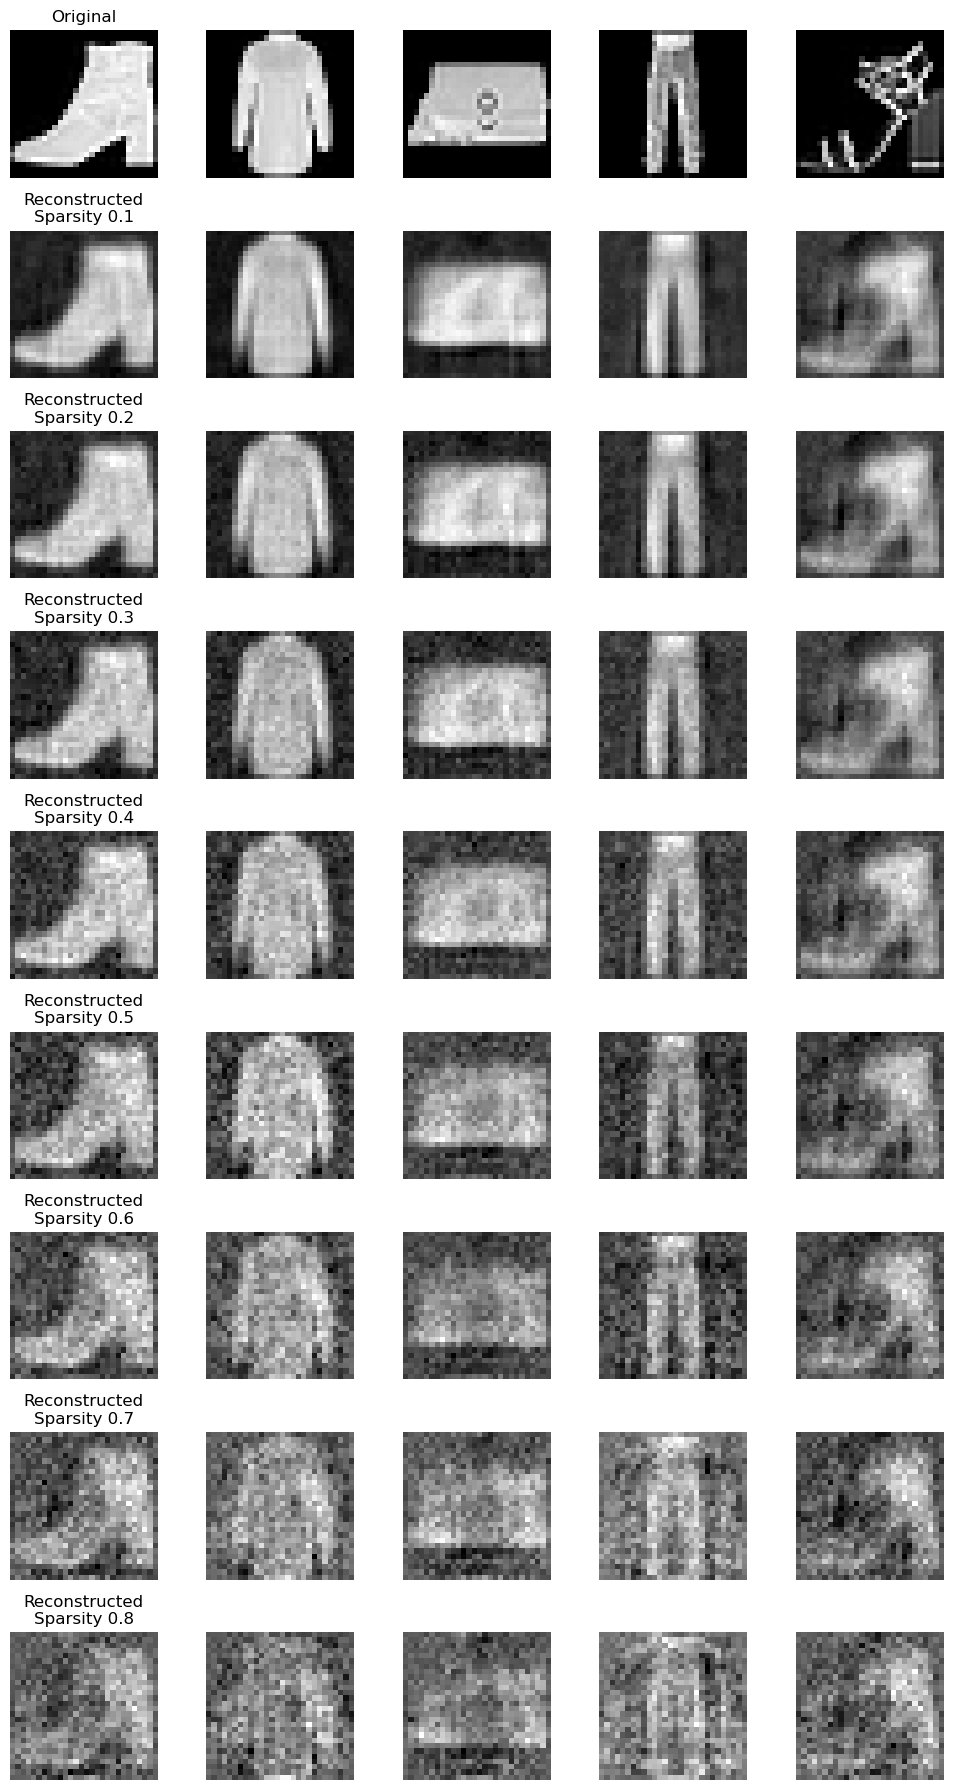

In [17]:
import matplotlib.pyplot as plt
import torch
import copy

def display_reconstructed_images(model, test_dataloader, prune_ratios):
    # Select a batch of images from the test DataLoader.
    test_images, _ = next(iter(test_dataloader))
    original_images = test_images.view(test_images.size(0), -1)

    # Set the number of images to display
    num_images_to_show = 5
    fig, axes = plt.subplots(len(prune_ratios) + 1, num_images_to_show, figsize=(num_images_to_show * 2, 2 * (len(prune_ratios) + 1)))

    # Display original images
    for i in range(num_images_to_show):
        ax = axes[0][i]
        ax.imshow(original_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

    # Display reconstructed images at each sparsity level
    for j, sparsity in enumerate(prune_ratios, start=1):
        # Prune the model copy at the current sparsity level
        pruned_model = copy.deepcopy(model)
        apply_lap(pruned_model, [sparsity] * len(pruned_model.hidden_sizes), bn_factors=None)

        # Generate reconstructed images from the pruned model
        pruned_model.eval()
        with torch.no_grad():
            reconstructed_images = pruned_model(original_images).cpu()

        # Plot the reconstructed images
        for i in range(num_images_to_show):
            ax = axes[j][i]
            ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')  # Adjust dimensions for your dataset
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Reconstructed\nSparsity {sparsity}')

    plt.tight_layout()
    plt.show()

# Assuming 'model' is the trained AutoEncoder, 'test_dataloader' is defined,
# and 'prune_ratios' is a list of desired sparsity levels
display_reconstructed_images(model, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])


In [19]:
data = 'DataPreparation/CorruptedMNIST/Names.csv'
root_dir = 'DataPreparation/CorruptedMNIST'
dataset =   data_set = datasets.MNIST("./", download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 95311229.10it/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 61070709.23it/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw


In [34]:
# finding the best parameters for autoencoder 
train_size = int(0.8 * len(dataset))  # 80% for training
validation_size = int(0.1*len(dataset))
test_size = len(dataset)-(train_size+validation_size)
train_dataset,validation_dataset,test_dataset,_ = random_split(dataset,[0.3,0.1,0.1, 0.5])
print(train_size)
print(validation_size)

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=True)

48000
6000


In [21]:
model_MNIST = AutoEncoder(input_size=784,bottleneck_size=50,hidden_sizes=[128, 64] ,layers=2)
train_losses,val_losses = train_autoencoder(model_MNIST, train_loader=train_dataloader,val_loader=validation_dataloader,epochs=100,lr=0.0003)

Epoch 1, Train Loss: 0.0621, Val Loss: 0.0420
Epoch 2, Train Loss: 0.0361, Val Loss: 0.0326
Epoch 3, Train Loss: 0.0299, Val Loss: 0.0279
Epoch 4, Train Loss: 0.0262, Val Loss: 0.0252
Epoch 5, Train Loss: 0.0240, Val Loss: 0.0236
Epoch 6, Train Loss: 0.0227, Val Loss: 0.0224
Epoch 7, Train Loss: 0.0215, Val Loss: 0.0213
Epoch 8, Train Loss: 0.0205, Val Loss: 0.0204
Epoch 9, Train Loss: 0.0197, Val Loss: 0.0196
Epoch 10, Train Loss: 0.0190, Val Loss: 0.0191
Epoch 11, Train Loss: 0.0184, Val Loss: 0.0185
Epoch 12, Train Loss: 0.0180, Val Loss: 0.0181
Epoch 13, Train Loss: 0.0176, Val Loss: 0.0177
Epoch 14, Train Loss: 0.0172, Val Loss: 0.0173
Epoch 15, Train Loss: 0.0168, Val Loss: 0.0170
Epoch 16, Train Loss: 0.0165, Val Loss: 0.0167
Epoch 17, Train Loss: 0.0162, Val Loss: 0.0164
Epoch 18, Train Loss: 0.0159, Val Loss: 0.0162
Epoch 19, Train Loss: 0.0157, Val Loss: 0.0160
Epoch 20, Train Loss: 0.0155, Val Loss: 0.0157
Epoch 21, Train Loss: 0.0153, Val Loss: 0.0155
Epoch 22, Train Loss: 

In [22]:
with open("Classifiers/MNISTClassifier_no_noise.pkl", "rb") as f:
    mnist_classifier = pickle.load(f)

In [35]:
import copy
import matplotlib.pyplot as plt
from Pruning.LookaheadPruning import apply_lap, calculate_sparsity

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels_LAP = []  # This will store the actual sparsity levels calculated from the model
test_losses_LAP = []

for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model_MNIST)
    
    # Apply LAP pruning using the specified prune ratio
    apply_lap(pruned_model, [ratio] * len(pruned_model.hidden_sizes), bn_factors=None)
    
    # Calculate the actual sparsity level of the pruned model
    sparsity = calculate_sparsity(pruned_model)
    sparsity_levels_LAP.append(sparsity)
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, mnist_classifier)
    test_losses_LAP.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


Prune Ratio: 0.2, Actual Sparsity Level: 0.1796, Test Loss: 0.9832
Prune Ratio: 0.3, Actual Sparsity Level: 0.2694, Test Loss: 0.9830
Prune Ratio: 0.4, Actual Sparsity Level: 0.3592, Test Loss: 0.9827
Prune Ratio: 0.5, Actual Sparsity Level: 0.4490, Test Loss: 0.9793
Prune Ratio: 0.6, Actual Sparsity Level: 0.5388, Test Loss: 0.9665
Prune Ratio: 0.7, Actual Sparsity Level: 0.6286, Test Loss: 0.9505
Prune Ratio: 0.8, Actual Sparsity Level: 0.7184, Test Loss: 0.8433
Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.3533


In [24]:
test_data = [data for data in test_dataloader]
importances_mnist = SSAE.calc_importance(model_MNIST,test_data[0][0])

0it [00:00, ?it/s]
100%|██████████| 8/8 [00:55<00:00,  6.88s/it]
1it [00:55, 55.07s/it]
100%|██████████| 21/21 [02:26<00:00,  6.97s/it]
3it [03:21, 68.50s/it]
100%|██████████| 251/251 [28:41<00:00,  6.86s/it]
5it [32:02, 384.51s/it]


In [36]:
import Pruning.ShapSAE as SSAE

# Assuming 'model' is your pre-trained AutoEncoder and 'test_dataloader' is defined
prune_ratios = [0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]  # Define desired prune ratios to apply
sparsity_levels = []  # This will store the actual sparsity levels calculated from the model
test_losses = []
pruned_model = copy.deepcopy(model_MNIST)



for ratio in prune_ratios:
    # Create a deep copy of the trained model to apply pruning
    pruned_model = copy.deepcopy(model_MNIST)
    
    # Apply LAP pruning using the specified prune ratio
    pruned_model, _ = SSAE.prune(pruned_model, importances_mnist, ratio)
    
    
    # Evaluate the pruned model on the test dataset
    test_loss = eval_model(pruned_model, test_dataset, mnist_classifier)
    test_losses.append(test_loss)
    print(f"Prune Ratio: {ratio}, Actual Sparsity Level: {sparsity:.4f}, Test Loss: {test_loss:.4f}")


5it [00:00, 714.63it/s]


Prune Ratio: 0.2, Actual Sparsity Level: 0.8082, Test Loss: 0.2003


5it [00:00, 1000.22it/s]


Prune Ratio: 0.3, Actual Sparsity Level: 0.8082, Test Loss: 0.1708


5it [00:00, 1000.26it/s]


Prune Ratio: 0.4, Actual Sparsity Level: 0.8082, Test Loss: 0.1195


5it [00:00, 1000.17it/s]


Prune Ratio: 0.5, Actual Sparsity Level: 0.8082, Test Loss: 0.1187


5it [00:00, 1000.17it/s]


Prune Ratio: 0.6, Actual Sparsity Level: 0.8082, Test Loss: 0.1187


5it [00:00, 999.69it/s]


Prune Ratio: 0.7, Actual Sparsity Level: 0.8082, Test Loss: 0.1187


5it [00:00, 999.83it/s]


Prune Ratio: 0.8, Actual Sparsity Level: 0.8082, Test Loss: 0.1187


5it [00:00, 1000.17it/s]


Prune Ratio: 0.9, Actual Sparsity Level: 0.8082, Test Loss: 0.1187


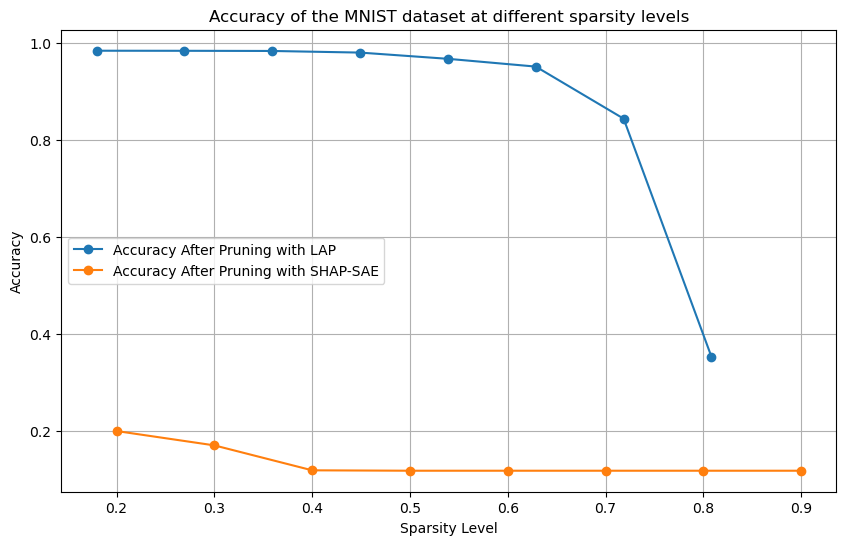

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels_LAP, test_losses_LAP, '-o', label='Accuracy After Pruning with LAP')
plt.plot(prune_ratios, test_losses, '-o', label='Accuracy After Pruning with SHAP-SAE')

plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Accuracy of the MNIST dataset at different sparsity levels')
plt.legend()
plt.grid(True)
plt.show()

5it [00:00, 833.29it/s]
5it [00:00, 833.46it/s]
5it [00:00, 1000.02it/s]
5it [00:00, 1000.45it/s]
5it [00:00, 999.36it/s]
5it [00:00, 1000.79it/s]
5it [00:00, 833.06it/s]
5it [00:00, 1000.02it/s]


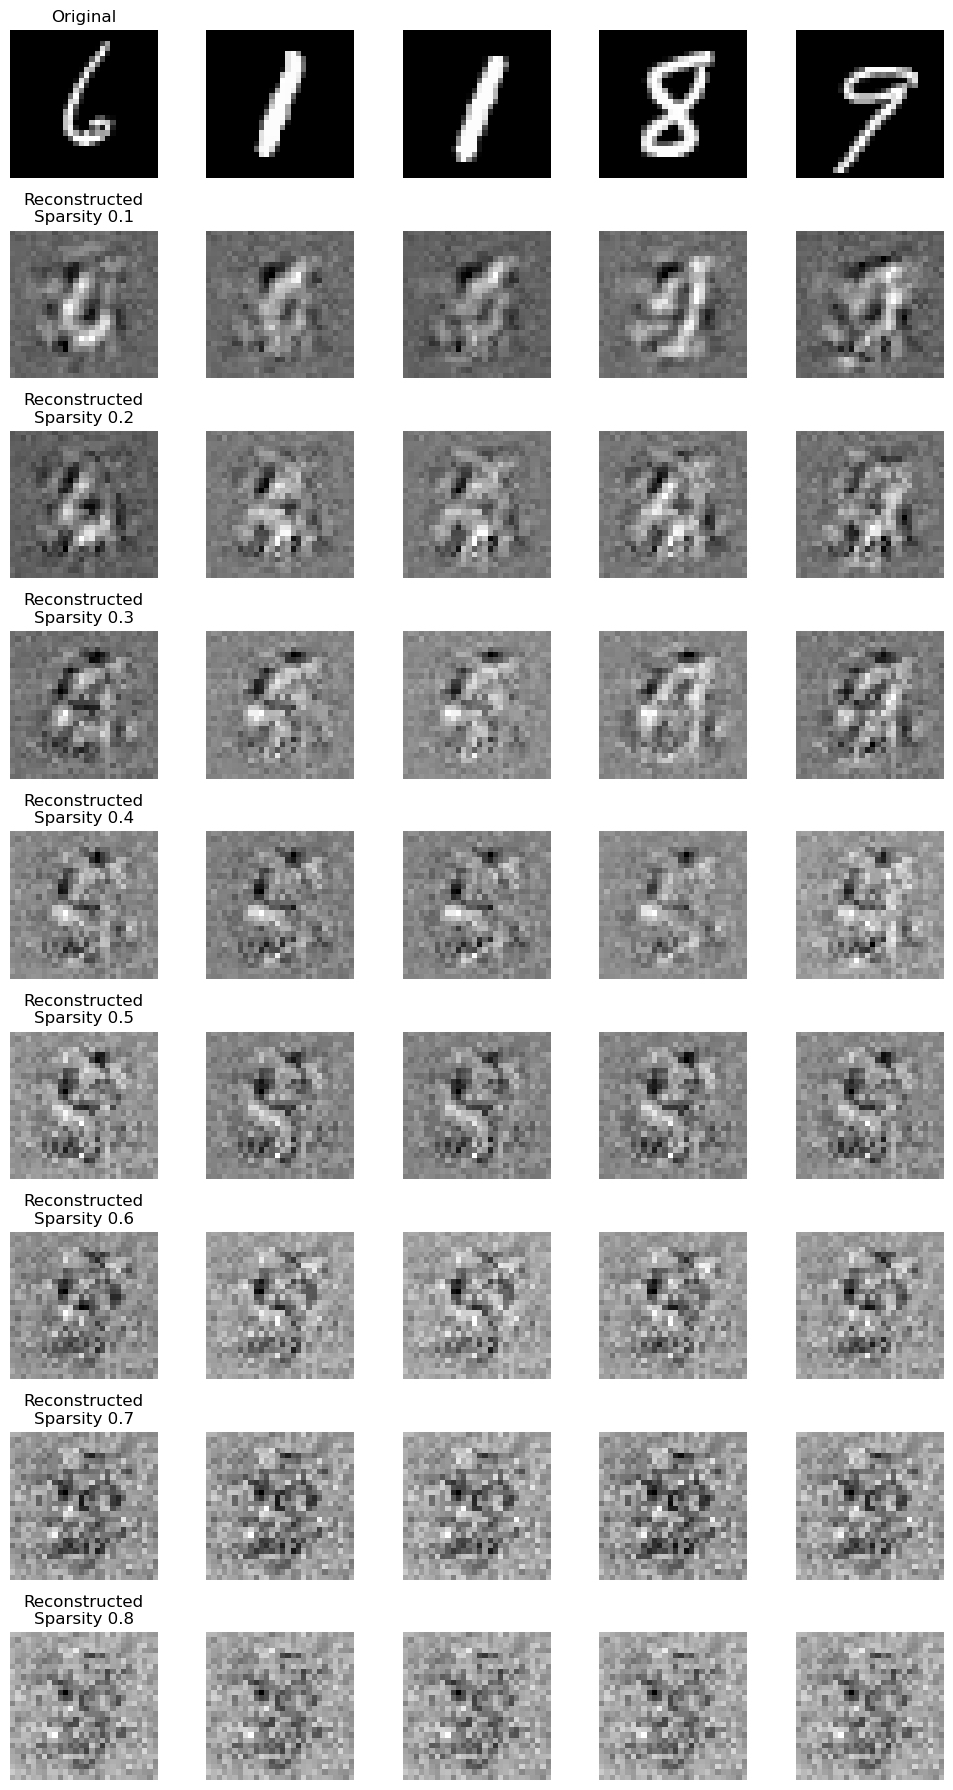

In [27]:
display_reconstructed_images_SHAP(model_MNIST, test_dataloader, importances, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

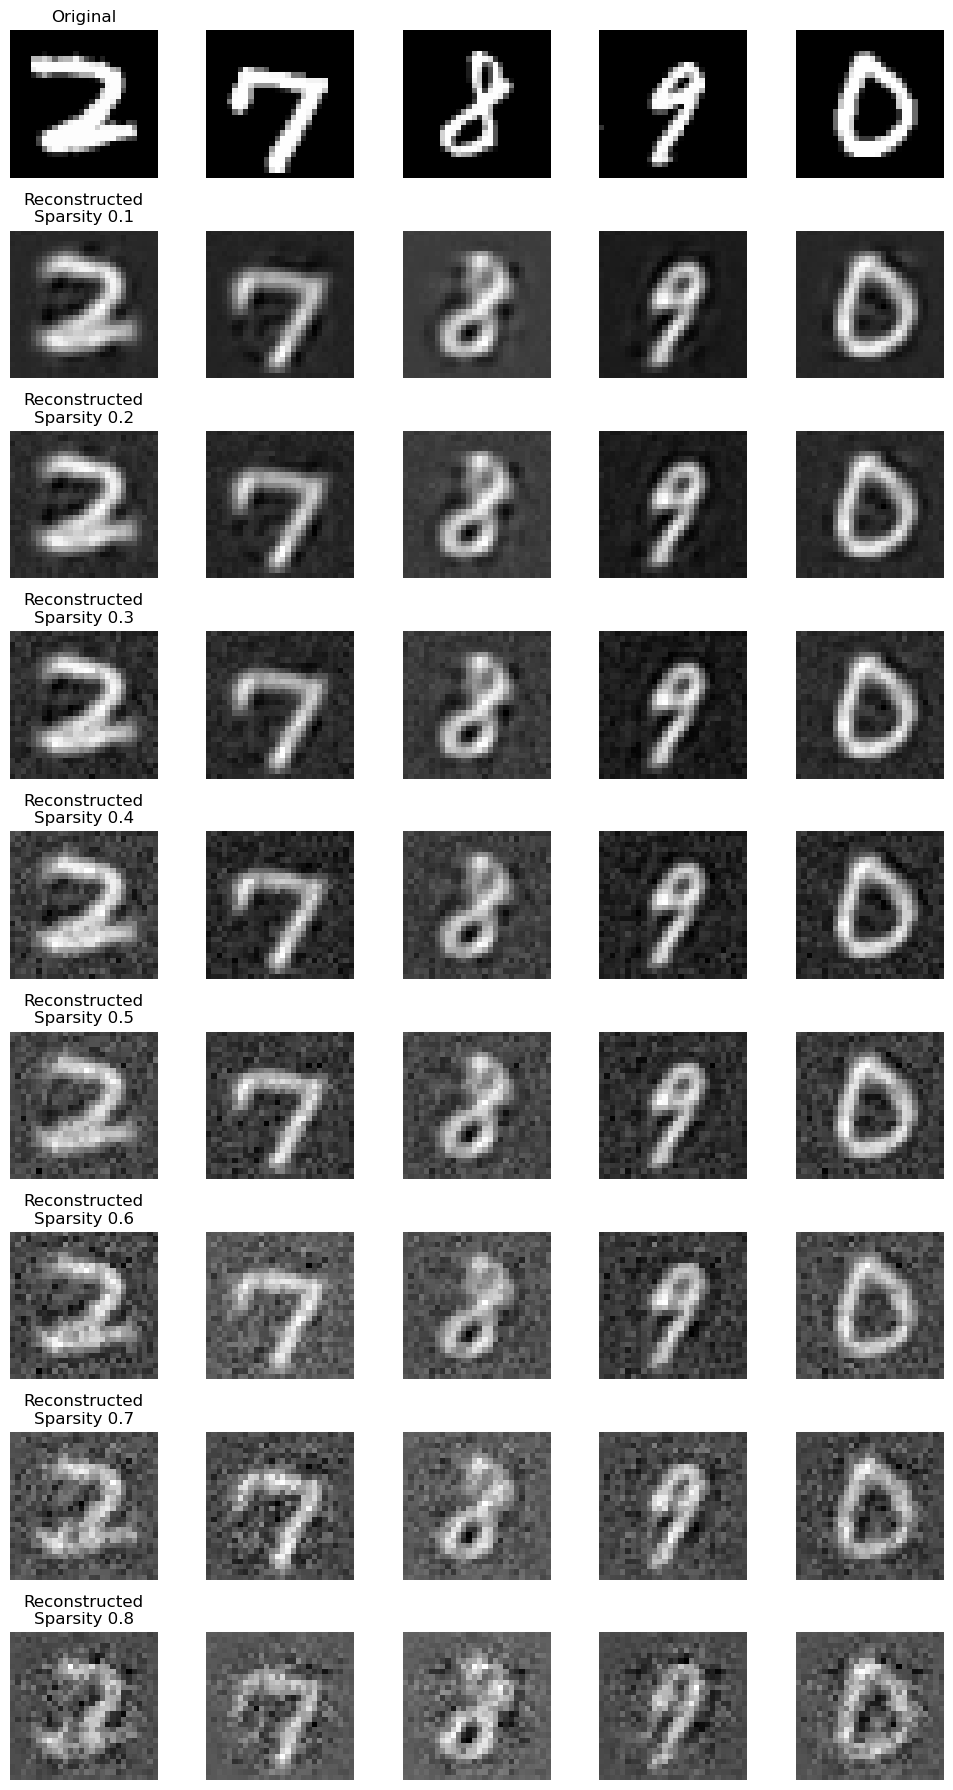

In [28]:
display_reconstructed_images(model_MNIST, test_dataloader, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])